In [1]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
dataset = ImageFolder(root='/content/train', transform=transform,
                      target_transform=lambda class_id: torch.tensor([class_id], dtype=torch.float))

In [6]:
from torch import nn
import torch.nn.functional as F
from torchvision import models


class TextClassifier(nn.Module):
    """
    Model with pretrained vgg19_bn feature extractor.
    Require 256x256 input image size
    """
    def __init__(self, num_classes=10):
        super().__init__()

        # pretrained model
        vgg = models.vgg19_bn(weights=models.VGG19_BN_Weights.DEFAULT)

        for param in vgg.parameters():
            param.requires_grad = False

        in_features = vgg.classifier[0].in_features

        vgg.classifier = nn.Identity()

        self.feature_extractor = vgg

        # trainable part
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(in_features, num_classes)


    def forward(self, x):
        out = self.feature_extractor(x)

        out = self.dropout(out)
        out = self.linear(out)
        out = F.sigmoid(out)

        return out


model = TextClassifier(num_classes=1).to(device)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 169MB/s]


In [7]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

In [8]:
import time
from sklearn.model_selection import KFold


def step(model, optimizer, loss_fn, dataloader,
         metrics, metrics_name, device,
         history, mode):
    """
    Perform one training or validation step depending on the mode parameter.

    Args:
        model (torch.nn.Module):
            neural network model used for training or validation

        optimizer (torch.optim.Optimizer):
            optimizer for updating model parameters

        loss_fn (torch.nn.Module):
            loss function

        dataloader (torch.utils.data.DataLoader):
            dataloader object providing batches of data

        metrics (list):
            list of functions to compute evaluation metrics
            functions should be in form func(y_true, y_pred)

        metrics_name (list):
            list of strings representing names corresponding to each metric function in `metrics`

        device (torch.device):
            device (CPU or GPU) on which to perform computations

        history (dict):
            dictionary to store and accumulate the loss and metrics values across batches
            if mode='val' all keys have prefix 'val_'

        mode (str):
            specifies whether to perform a training ('train') or validation ('val') step
    """

    if mode == 'train':
        model.train()
        prefix = ''
    else:
        model.eval()
        prefix = 'val_'

    for batch in dataloader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        y_pred = y_pred.detach().cpu().numpy()
        y_pred = y_pred.round()
        y = y.detach().cpu().numpy()

        # multiplier factor for averaging loss amd metrics per batch
        multiplier = x.size(0) / len(dataloader.dataset)

        history[prefix+'loss'] += loss.item() * multiplier
        for name, func in zip(metrics_name, metrics):
            history[prefix+name] += func(y, y_pred) * multiplier


def cross_validation_step(model, optimizer, loss_fn, dataset,
                          metrics, metrics_name, device, kfold):
    """
    Perform one cross-validation step for training and validation

    Args:
        model (torch.nn.Module):
            neural network model used for training or validation

        optimizer (torch.optim.Optimizer):
            optimizer for updating model parameters

        loss_fn (torch.nn.Module):
            loss function

        dataset (torch.utils.data.Dataset):
            dataset object containing data for cross-validation

        metrics (list):
            list of functions to compute evaluation metrics
            functions should be in form func(y_true, y_pred)

        metrics_name (list):
            list of strings representing names corresponding to each metric function in `metrics`

        device (torch.device):
            device (CPU or GPU) on which to perform computations

        kfold (sklearn.model_selection.KFold):
            The k-fold cross-validation object that provides train/validation
            splits.

    Returns:
        tuple:
            A tuple containing two dictionaries:
            - `history_train`: A dictionary accumulating training metrics across folds
            - `history_val`: A dictionary accumulating validation metrics across folds
              Both dictionaries have keys for 'loss' and each metric in `metrics_name`,
              prefixed with 'val_' for validation metrics.
    """

    history_train = {name: 0 for name in ['loss']+metrics_name}
    history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

    for train_ids, val_ids in kfold.split(dataset):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        train_dl = torch.utils.data.DataLoader(dataset, batch_size=len(train_ids), sampler=train_subsampler)
        val_dl = torch.utils.data.DataLoader(dataset, batch_size=len(train_ids), sampler=val_subsampler)

        step(model, optimizer, loss_fn, train_dl,
             metrics, metrics_name, device,
             history_train, mode='train')

        with torch.no_grad():
            step(model, optimizer, loss_fn, val_dl,
                 metrics, metrics_name, device,
                 history_val, mode='val')

    return history_train, history_val


def train(model, optimizer, scheduler, loss_fn, dataset,
          metrics=None, epochs=20, device='cpu',
          k_folds=3):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data
    using cross-validation.

    Args:
        model (torch.nn.Module):
            neural network model to be trained

        optimizer (torch.optim.Optimizer)
            optimizer algorithm for updating model parameters

        scheduler (torch.optim.lr_scheduler._LRScheduler)
            Learning rate scheduler to adjust learning rate based on validation loss

        loss_fn (torch.nn.Module):
            loss function

        dataset (torch.utils.data.Dataset):
            dataset object containing data for cross-validation

        metrics (list, optional):
            list of functions to compute evaluation metrics
            functions should be in form func(y_true, y_pred)
            default None

        epochs (int, optional):
            number of epochs to train the model, default 20

        device (torch.device):
            device (CPU or GPU) on which to perform computations, default cpu

        k_folds (int, optional):
            number of folds for cross-validation, default 3

    Returns:
        dict
            dictionary containing per-epoch history of training loss, validation loss,
            and metrics (if provided). Keys include 'loss', 'val_loss', and metrics names
            prefixed with 'val_' for validation metrics.
    '''

    print('Start training model')

    metrics = metrics if metrics else []
    metrics_name = [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    kfold = KFold(n_splits=k_folds, shuffle=True)

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        history_train, history_val = cross_validation_step(
            model, optimizer, loss_fn, dataset,
            metrics, metrics_name, device, kfold
            )

        end_time_epoch = time.time()

        for name in history_train:
            # append mean value of metrics from cross-validation
            history[name].append(history_train[name] / (k_folds-1))
            history['val_'+name].append(history_val['val_'+name])

        scheduler.step(history['val_loss'][-1])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print(f'Time total:     {total_time_train: 5.0f}sec')

    return history

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, scheduler, loss_fn, dataset,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                k_folds=3
                )

Start training model
Epoch    1    5sec	loss:      0.539	val_loss:       0.61	accuracy_score:      0.812	val_accuracy_score:      0.786	
Epoch    2    3sec	loss:      0.237	val_loss:      0.448	accuracy_score:      0.946	val_accuracy_score:      0.946	
Epoch    3    3sec	loss:      0.123	val_loss:      0.283	accuracy_score:      0.991	val_accuracy_score:      0.964	
Epoch    4    4sec	loss:     0.0762	val_loss:      0.164	accuracy_score:          1	val_accuracy_score:      0.982	
Epoch    5    4sec	loss:     0.0369	val_loss:     0.0936	accuracy_score:          1	val_accuracy_score:          1	
Epoch    6    4sec	loss:     0.0288	val_loss:     0.0525	accuracy_score:          1	val_accuracy_score:          1	
Epoch    7    3sec	loss:      0.022	val_loss:     0.0455	accuracy_score:          1	val_accuracy_score:      0.982	
Epoch    8    4sec	loss:     0.0214	val_loss:     0.0277	accuracy_score:          1	val_accuracy_score:          1	
Epoch    9    4sec	loss:     0.0214	val_loss:     0

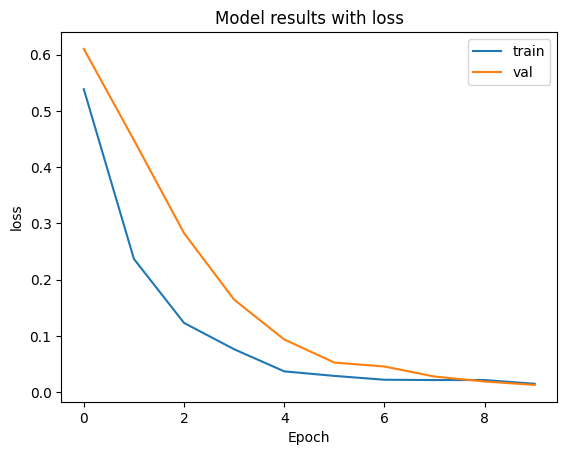

In [10]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    """
    Plot the training and validation metric over epochs.

    Args:
        history (dict):
            dictionary containing the per-epoch history of metrics

        name (str):
            The name of the metric to plot. This should match a key in `history`
    """

    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

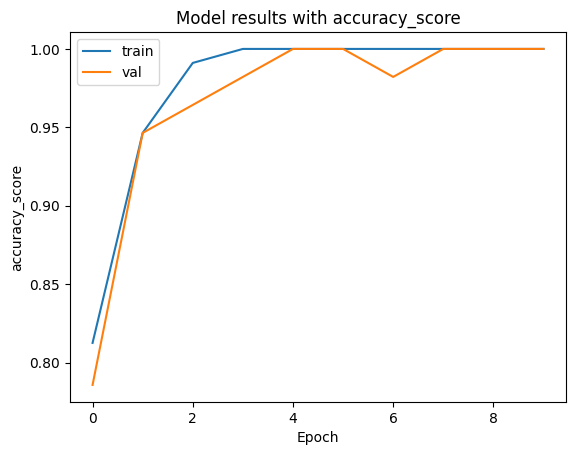

In [11]:
plot_metric(history, 'accuracy_score')

[]

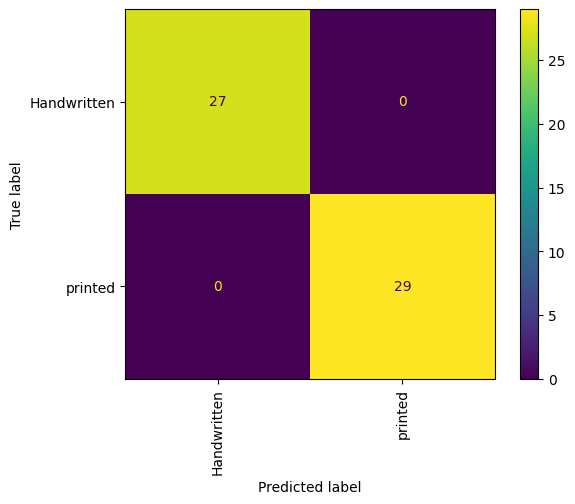

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay


loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
X, y = next(iter(loader))

with torch.no_grad():
    model.eval()
    X = X.to(device)
    y_pred = model(X)
    y_pred = y_pred.cpu()
    y_pred = y_pred.round()

ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=dataset.classes)
plt.xticks(rotation=90)
plt.plot()

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

 Handwritten       1.00      1.00      1.00        27
     printed       1.00      1.00      1.00        29

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



In [15]:
torch.save(model.state_dict(), 'weights.pt')

In [16]:
load_model = TextClassifier(num_classes=1).to(device)
load_model.load_state_dict(torch.load('weights.pt'))

<All keys matched successfully>